<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## Kerry Kurcz
### MSDS453 - Research Assignment 02
#### Classification and Clustering
##### Code based on https://github.com/djp840/MSDS_453_Public

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:

# doc2vec - from first assignment


In [2]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim # https://pypi.org/project/gensim/
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from time import asctime
import unicodedata

#import pkg_resources
#pkg_resources.require("gensim<=3.8.3");
#print("Genism Version: ", gensim.__version__)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def get_time(please_print=False):
    TIME = asctime().replace(" ", "").replace(":", "")
    TIME = re.sub(r'[A-z]', '', TIME)
    if please_print:
        print("The current time is", TIME)
    return TIME

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_recall_fscore_support

from textblob import TextBlob

In [3]:
TIME = get_time(please_print=True)

The current time is 231633202022


In [4]:
PATH = "/Users/kerry/Projects/msds453/random_nlp/week4"

<div class="alert alert-block alert-info">
<b> NLTK downloads </b>
</div>

### NLTK Downloads

In [5]:
# Only run this once, they will be downloaded.
#nltk.download('stopwords',quiet=True)
#nltk.download('wordnet',quiet=True)
#nltk.download('punkt',quiet=True)
#nltk.download('omw-1.4',quiet=True)
#nltk.download('universal_tagset')

## Data Wrangling Utility Functions

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Doc2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Doc2Vec Matrix creation

In [6]:
def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)


# doc a 2 vec a

In [7]:
@dataclass
class Document:
    doc_id: str
    text: str

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]
        
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

    
def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)
        
    return documents


def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)    
    
    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)
    
    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)
    
    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_tsne(doc2vec_df, 30, experiment_name)

## Topic Modeling Functions: LSA

In [8]:
def lsa(tfidf_matrix, n_components = 10):
    """
    trash, but keeping here bc printing the attritubes make me feel like I know what I'm doing
    """
    
    LSA = TruncatedSVD(n_components=10)
    FIT = LSA.fit(X=tfidf_matrix) # X is training data; {array-like, sparse matrix} of shape (n_samples, n_features)
    
#    print("components")
#    print(LSA.components_)
#    print("explained variance")
#    print(LSA.explained_variance_)
#    print("explained variance ratio")
#    print(LSA.explained_variance_ratio_)
    print("n features in")
    print(LSA.n_features_in_)
#    print("feature names")
#    print(LSA.feature_names_in_)
    
    return FIT


def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Creating the term dictionary of our courpus, 
    where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    """
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix # vector of unique terms per doc for all docs; try with tfitdf? doc2vec?
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100
                       )

    print(f"greetings. printing model topic observations for n topics {number_of_topics}")
    for idx, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
        print(f"topic {idx}")
        print(topic)
        print("\n")

    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [9]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title, clusters, frame, km

def classifiers(x, y, model_type, results_tbl, sent_or_gen, cv=3):

    if model_type == 'svm':
        model = SVC()
        
    if model_type == 'logistic':
        if sent_or_gen=='gen':
            model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
        elif sent_or_gen=='sent':
            model = LogisticRegression() 

    elif model_type == 'naive_bayes':
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        model = RandomForestClassifier()
        
    accy = []
    prcn = []
    rcl = []
    fsc = []
    roc = []
        
    for idx in range(0, cv):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)
        
        accy.append(accuracy_score(y_test, predictions))
        if sent_or_gen=='gen':
            roc.append(1)
#            roc.append(roc_auc_score(y_test, predictions, multi_class='ovo')) # :(
        else:
            roc.append(roc_auc_score(y_test, predictions))
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, 
                                                                             predictions, 
                                                                             average='weighted')
        
        prcn.append(precision)
        rcl.append(recall)
        fsc.append(fscore)
        if sent_or_gen=='gen':
            roc_val = "-" # there was an issue with the dimension of inputs? I think it wanted labels
        else:
            roc_val = sum(roc)/len(roc)

    results_tbl = results_tbl.append({'Classifier_Type': model_type,
                                      'cv_value': cv,
                                      'Sentiment_or_Genre': sent_or_gen,
                                      'Accuracy': sum(accy)/len(accy),
                                      'Precision': sum(prcn)/len(prcn),
                                      'ROC_AUC': roc_val,
                                      'Recall': sum(rcl)/len(rcl),
                                      'F1': sum(fsc)/len(fsc),
                       }, 
                       ignore_index = True)
        
    return results_tbl

## Visualization Utility Functions

In [10]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_kmeans(k_value, dimensions=2):
    """
    clusters is a list of 0,1,1,2,3,2,1 if you have like 4 clusters
    cluster_dict is a dictionary; {0: [all, the docs, in, cluster 0], . . . k: ['doc1', 'docwhatever']}
    k_means_df is a df with an index no one uses, a cluster (same as clusters),
        a doc name, and the text in that document
    k_value is value for k clusters pleS
    
    flipping yikes: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    """
    cluster_dict, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = k_value)

    #mds = MDS(n_components = dimensions, dissimilarity = "precomputed", random_state = 8675309)
    mds = MDS(n_components = dimensions, dissimilarity = "euclidean", random_state = 8675309)
    # Multi-Dimensional Scaling . . . used for perceptual mapping
    # Similar to PCA. . . .
    # Metric Multidimensional Scaling is often used for Perceptual Mapping 
    # (creating maps based on a different-than-usual measure of distance) and for Product Development.
    # source : https://towardsdatascience.com/multidimensional-scaling-d84c2a998f72#:~:text=Metric%20Multidimensional%20Scaling%20is%20often,distance)%20and%20for%20Product%20Development.
    
    dist = 1 - cosine_similarity(tfidf_matrix) # 1 - cosine_similarity(TFIDF_matrix) | dist = 1 + cosine_similarity(TFIDF_matrix)
    # dist is 200 x 200
    
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples) i.e. 200 x (2 or 3 . . .nbr of dimensions)
    if dimensions==2:
        xs, ys = pos[:, 0], pos[:, 1]
        df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 
    else:
        xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
        df = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters, title=range(0,len(clusters)))) 

    # df , of shape 200 x (4 or 5), 
    # has the result of the MDS plus the cluster numbers and titles
    
    # then group by cluster
    groups = df.groupby('label')
    
    if dimensions == 2:
        fig, ax = plt.subplots(figsize=(20,20)) # set size
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    else:
        fig = plt.figure(figsize = (15,15))
        ax = fig.add_subplot(111, projection='3d')

    for name, group in groups:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        if dimensions==2:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label = (f"cluster {group.label.iloc[0]}"), color=color, 
                mec='none')
            
        else:
            ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=12,
                    label = (f"cluster {group.label.iloc[0]}"), color=color, 
                    mec='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if dimensions==3:
        ax.set_zlabel('z')
    
    plt.title(f"k-means cluster plot given k={k_value} and dimensions={dimensions}")

    ax.legend(loc='lower left')

    TIME = get_time()
    plt.savefig(f"{PATH}/{TIME}_cluster.png")
    
    # prints the clusters for reference
    for KEY, VAL in cluster_dict.items():
        print(f"cluster {KEY} : ", VAL, "\n")


In [ ]:
funny_silly_chars = 0

In [11]:
def strip_accents(STR):
    funny_silly_chars += 1
    return_STR = ''.join(abc for abc in unicodedata.normalize('NFD', STR)
                   if unicodedata.category(abc) != 'Mn')
    
    return 

def clean_doc(doc, more_stop_words=[]): 
    """
    Sometimes you need bleach,
    sometimes CLR.
    sometimes you wash the walls
    sometimes the floors.
    """
    
    # remove capital letters after a .
    doc = doc.replace("-", "_")
    doc = re.sub(r"[?!.][A-Z]", lambda mno: mno.group().lower(), doc) # 'the quick. Brown fox' -> 'the quick. brown fox' 
    doc = re.sub(r"[?!.] [A-Z]", lambda mno: mno.group().lower(), doc) # 'the quick!Brown fox' -> 'the quick!brown fox' 
    doc = re.sub(r"[\d]", ' ', doc)    
    strip_accents(doc) # replaces non-ascii with utf-friendly chars; except doesn't replace as much as counts how many troublemakers
    doc = re.sub(r'[^\x00-\x7F]', ' ', doc) # removes any remaining non-ascii chars
    tagged_doc = nltk.tag.pos_tag(doc.split())
    tokens = [word for word, tag in tagged_doc if tag != 'NNP' and tag != 'NNPS']
    
    #tokens = doc.split() # if needed
    
    # punctuation situation
#    sub_punc = re.compile('[%s]' % re.escape(string.punctuation))
#    tokens = [sub_punc.sub('', tkn) for tkn in tokens]
    
    stop_words = set(stopwords.words('english') + more_stop_words + ["Queen"])
    tokens = [tkn for tkn in tokens if not tkn in stop_words]

    def please(tokens):
        """
        asking nicely for this hack to give me
        results that aren't sad
        """
        lemmatizer = WordNetLemmatizer()
        some_list = nltk.tag.pos_tag(tokens, 'universal') 
        new_list = []
        for word,tag in some_list:
            if tag == 'VERB':
                tag = 'v'
            elif tag == "ADJ":
                tag = 'a'
            elif tag == "ADV":
                tag = 'r'
            else:
                tag = 'n'
            new_list.append(lemmatizer.lemmatize(word, tag))
        return new_list
    
    tokens = please(tokens)
    
    tokens = [tkn for tkn in tokens if tkn != '']
    tokens = [tkn for tkn in tokens if len(tkn) > 3]
    
    return tokens # tokens is a list

## Loading the Class Corpus & Cleaning

In [12]:
#read in class corpus csv into python
data = pd.read_csv(r'~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv')

In [13]:
data.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Negative,Taxi
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Negative,Taxi


In [14]:
## adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

## getting the top freq qords so I can add them to stop_words
data['word_count'] = data['processed_text'].apply(lambda xyz : [idx[0] for idx in nltk.FreqDist(xyz).most_common(30)])
more_stop_words = [idx[0] for idx in nltk.FreqDist([abc for xyz in data.word_count.to_list() for abc in xyz]).most_common(100)]

In [15]:
##read in class corpus csv into python
data=pd.read_csv(r'~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v5_20220717.csv')

##adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x, more_stop_words))

data['sentiments'] = data.Text.apply(lambda xyz: TextBlob(xyz).sentiment)
data['polarity'] = data.sentiments.apply(lambda abc: abc[0])
data['subjectivity'] = data.sentiments.apply(lambda abc: abc[1])

# changing the truth to conform to the textblob
data["Review Type (pos or neg)"] = np.where(data["polarity"] > 0, 'Positive', 'Negative')

In [16]:
data.loc[data['Movie Title']=='The Toxic Avenger']

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text,sentiments,polarity,subjectivity
90,60,KKN_Doc1_ToxicAvenger,This film believe or not is one of my favorate...,KKN_Doc1_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[This, believe, favorate, film, time,, kinda, ...","(0.14469079726089076, 0.4800603083313364)",0.144691,0.480060
91,61,KKN_Doc2_ToxicAvenger,"When I was a teenager, the only available plac...",KKN_Doc2_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[When, teenager,, available, place, trash, sho...","(0.020453586497890294, 0.5531072935503315)",0.020454,0.553107
92,62,KKN_Doc3_ToxicAvenger,I've never seen a Troma film before but I do r...,KKN_Doc3_ToxicAvenger,KerryKurcz,Horror,Negative,The Toxic Avenger,"[remember, watch, ""Toxic, cartoon, vague, awar...","(-0.06267597578573186, 0.544824112202161)",-0.062676,0.544824
93,63,KKN_Doc4_ToxicAvenger,Toxic Avenger 21st Anniversary Ed. 2 Disc Set ...,KKN_Doc4_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[torment, innocent, janitor, fall, toxic, wast...","(0.09498409753511795, 0.5776967930029154)",0.094984,0.577697
94,64,KKN_Doc5_ToxicAvenger,The Toxic Avenger is an excellent and hilariou...,KKN_Doc5_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[excellent, hilarious, combines,wonderful, dir...","(0.22663829340058855, 0.5899431033447424)",0.226638,0.589943
95,65,KKN_Doc6_ToxicAvenger,I can say the most positive thing about The To...,KKN_Doc6_ToxicAvenger,KerryKurcz,Horror,Negative,The Toxic Avenger,"[positive, knew, was., sure,, horrible,, horri...","(-0.08835456995834352, 0.6099955076370172)",-0.088355,0.609996
96,66,KKN_Doc7_ToxicAvenger,The Toxic Avenger starts with a shot of the Ne...,KKN_Doc7_ToxicAvenger,KerryKurcz,Horror,Negative,The Toxic Avenger,"[start, shot, skyline., narration, informs, 'N...","(-0.052103783097759, 0.5260050157339314)",-0.052104,0.526005
97,67,KKN_Doc8_ToxicAvenger,I have to force myself not to give this movie ...,KKN_Doc8_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[force, anything, tempt, reason, force, pessim...","(0.1543372388481084, 0.5563674007152268)",0.154337,0.556367
98,68,KKN_Doc9_ToxicAvenger,Four crazed teenagers speed down the road in t...,KKN_Doc9_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[Four, crazed, teenager, speed, road, car,, wi...","(0.10009424603174603, 0.46806051587301595)",0.100094,0.468061
99,69,KKN_Doc10_ToxicAvenger,"In the world of movies, many know of the main ...",KKN_Doc10_ToxicAvenger,KerryKurcz,Horror,Positive,The Toxic Avenger,"[movies,, main, genre, cover, kind, stories., ...","(0.10149186671913943, 0.5052678602962695)",0.101492,0.505268


In [17]:
pd.set_option('display.max_rows', None)
data.sort_values('polarity').head(4)

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text,sentiments,polarity,subjectivity
64,34,PYC_Doc5_DirtyGrandpa,"My hopes were high for “Dirty Grandpa,” simply...",PYC_Doc5_DirtyGrandpa,PYC,Comedy,Negative,Dirty Grandpa,"[hope, high, simply, mere, existence, make, pr...","(-0.13255366161616167, 0.5740174062049062)",-0.132554,0.574017
67,37,PYC_Doc8_DirtyGrandpa,"On Jan. 22, “Dirty Grandpa” was unleashed on t...",PYC_Doc8_DirtyGrandpa,PYC,Comedy,Negative,Dirty Grandpa,"[unleashed, unsuspecting, American, public., p...","(-0.11500449236298291, 0.5065813117699911)",-0.115004,0.506581
52,142,ARB_Doc3_HolmesAndWatson,There's a moment during the stunningly abysmal...,ARB_Doc3_HolmesAndWatson,ARB,Comedy,Negative,Holmes and Watson,"[There's, stunningly, abysmal, look, screen, w...","(-0.10248015873015873, 0.6535714285714286)",-0.102480,0.653571
189,9,GGS_Doc10_Taken,Liam Neeson was up forbut never got to playJ...,GGS_Doc10_Taken,Gavyn Gallagher,Action,Negative,Taken,"[even., violent,, churn, laughably, derivative...","(-0.09499488936988941, 0.4445529701779702)",-0.094995,0.444553


In [18]:
# peer into the peaks

#data.loc[data.polarity==data.polarity.min()]
#data.loc[data.polarity==data.polarity.max()]
#data.loc[data.subjectivity==data.subjectivity.min()]
#data.loc[data.subjectivity==data.subjectivity.max()]

In [19]:
data.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text,sentiments,polarity,subjectivity
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Positive,Taxi,"[screen, career, start, complete, lack, screen...","(0.055480719044548835, 0.5215130023640662)",0.055481,0.521513
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,"[After, nominated, ""Chicago"", make, box_office...","(0.12941393097643097, 0.4301662457912458)",0.129414,0.430166
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,"[handily, walk, inEChicago., enliven, unevenEB...","(-0.0051391895141895145, 0.5485849137634852)",-0.005139,0.548585
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Positive,Taxi,"[leave, immediately, start, make, movies., cir...","(0.0489723417608033, 0.4628261161915007)",0.048972,0.462826
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Positive,Taxi,"[TaxiEcasts, bumble, lose, driver, license, ca...","(0.03721340388007054, 0.5719356261022929)",0.037213,0.571936


In [20]:
corpus_df = data.copy()
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

In [21]:
# if the same words start to appear across multiple topics, the number of topics is too high.
# source : https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
# plot all the coherences with all the number of words

In [22]:
# Example for detecting bigrams 
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents(data.processed_text)

# Filter only those that occur at least 2 times
finder.apply_freq_filter(2)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [23]:
bigram_pmi

,bigram,pmi
0,"('splosions, boobies.)",14.878171
21,"(laundry_list, guideline)",14.878171
23,"(memorize, predetermined)",14.878171
24,"(month_long, tour,)",14.878171
25,"(owner, bludgeons.)",14.878171
26,"(pampered, flouncer)",14.878171
27,"(poster,, goddamn)",14.878171
28,"(quirks., Have)",14.878171
29,"(rules;, shell)",14.878171
30,"(shell, form_fitting)",14.878171


In [24]:
print("bigram pmi standard deviation", round(bigram_pmi.pmi.std(), 2))
print("bigram pmi min", round(bigram_pmi.pmi.min(), 2))
print("bigram pmi min", round(bigram_pmi.pmi.max(), 2))
print("2 st devs less than max bigram pmi ", round(bigram_pmi.pmi.max() - 2 * bigram_pmi.pmi.std()))
print(". . .")
thresh = bigram_pmi.pmi.min() + bigram_pmi.pmi.std()
print("using a threshold of ", round(thresh, 2))

bigram pmi standard deviation 2.71
bigram pmi min 1.92
bigram pmi min 14.88
2 st devs less than max bigram pmi  9
. . .
using a threshold of  4.62


In [25]:
# Example filter for noun-type structures bigrams

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score

filtered_bigram = bigram_pmi[bigram_pmi.
                             apply(lambda bigram: 
                                   bigram_filter(bigram['bigram']) 
                                   and bigram.pmi > thresh, axis = 1)]

In [26]:
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values\
        if len(x[0]) > 2 or len(x[1]) > 2]

def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

##reviews_w_ngrams = data.copy()
##reviews_w_ngrams.reviewText = reviews_w_ngrams.processed_text.map(lambda x: replace_ngram(' '.join(x)))

data.processed_text = data.processed_text.map(lambda x: replace_ngram(' '.join(x)))

In [27]:
data.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text,sentiments,polarity,subjectivity
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Positive,Taxi,screen career start complete_lack screen_prese...,"(0.055480719044548835, 0.5215130023640662)",0.055481,0.521513
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,"After nominated ""Chicago"" make box_office spla...","(0.12941393097643097, 0.4301662457912458)",0.129414,0.430166
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,handily walk inEChicago. enliven unevenEBringi...,"(-0.0051391895141895145, 0.5485849137634852)",-0.005139,0.548585
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Positive,Taxi,leave immediately start make movies. circle li...,"(0.0489723417608033, 0.4628261161915007)",0.048972,0.462826
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Positive,Taxi,TaxiEcasts bumble lose driver_license cause th...,"(0.03721340388007054, 0.5719356261022929)",0.037213,0.571936


In [28]:
data[data.processed_text.apply(lambda xyz: "_" in ' '.join(xyz)) == True].processed_text[0]

'screen career start complete_lack screen_presence inETaxiEis indication. comedian, hoot news co_anchor "Saturday leave sketch season pursue stardom, virtually invisible next charismatic low_watt action_comedy alone frame, look scenery. fallon play wholly inept record wrecking frustrate lieutenant (Esposito) take driver\'s license. desperate prove hears bank heist report police radio, commandeers taxi driven takes_no_sass who, happens, customize seemingly average presto_change_o supercharge street rod. perfect car, perfect daredevil driver, chase_crook are, purely sake sell ticket _year_old boys, leggy Brazilian_model souped_up none asinine device (which iceberg) matter embrace absurdity, focus irony over_the_top action. stunt_driving lackluster picture\'s over_edited hide fact), director stop_dead_track pieces, sings along falsetto Will Based French action_comedy writer produce remake,ETaxiEis weakly script give_reason invest redemption complete_failure cop, care cursory attempt expla

In [29]:
data.processed_text = data.processed_text.apply(lambda xyz: xyz.split(" "))

In [30]:
data.head()

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text,sentiments,polarity,subjectivity
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Positive,Taxi,"[screen, career, start, complete_lack, screen_...","(0.055480719044548835, 0.5215130023640662)",0.055481,0.521513
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,"[After, nominated, ""Chicago"", make, box_office...","(0.12941393097643097, 0.4301662457912458)",0.129414,0.430166
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,"[handily, walk, inEChicago., enliven, unevenEB...","(-0.0051391895141895145, 0.5485849137634852)",-0.005139,0.548585
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Positive,Taxi,"[leave, immediately, start, make, movies., cir...","(0.0489723417608033, 0.4628261161915007)",0.048972,0.462826
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Positive,Taxi,"[TaxiEcasts, bumble, lose, driver_license, cau...","(0.03721340388007054, 0.5719356261022929)",0.037213,0.571936


In [31]:
final_processed_text = [' '.join(x) for x in data['processed_text']]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text']#.tolist()

In [32]:
' '.join(data[data.processed_text.apply(lambda xyz: "_" in ' '.join(xyz))==True].processed_text[0])

'screen career start complete_lack screen_presence inETaxiEis indication. comedian, hoot news co_anchor "Saturday leave sketch season pursue stardom, virtually invisible next charismatic low_watt action_comedy alone frame, look scenery. fallon play wholly inept record wrecking frustrate lieutenant (Esposito) take driver\'s license. desperate prove hears bank heist report police radio, commandeers taxi driven takes_no_sass who, happens, customize seemingly average presto_change_o supercharge street rod. perfect car, perfect daredevil driver, chase_crook are, purely sake sell ticket _year_old boys, leggy Brazilian_model souped_up none asinine device (which iceberg) matter embrace absurdity, focus irony over_the_top action. stunt_driving lackluster picture\'s over_edited hide fact), director stop_dead_track pieces, sings along falsetto Will Based French action_comedy writer produce remake,ETaxiEis weakly script give_reason invest redemption complete_failure cop, care cursory attempt expla

### K-Means Experiment with 3D Plot

## Exploritory Data Analysis

In [33]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)


def get_corpus_df(data):
#    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


@dataclass
class Document:
    doc_id: str
    text: str

In [34]:
#CORPUS_PATH = '~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v3_20220710.csv' # copy?
#corpus_df = get_corpus_df(CORPUS_PATH)
corpus_df = get_corpus_df(data)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [35]:
corpus_df.shape

(200, 13)

In [36]:
corpus_df.head().T

Doc_ID,42,40,41,43,44
DSI_Title,KCM_Doc3_AngelHasFallen,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Ric Roman Waughs Angel Has Fallen sees U.S. S...,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc3_AngelHasFallen,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Positive,Positive,Positive,Positive
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
processed_text,"[secret_agent_return, home, turf, trip, across...","[journey, change, clothes, comfortable., inste...","[people?, That, mutter, enter, screen, Fallen,...","[There, certain, mindless, pleasure, movies., ...","[and/or, Fallen, understand, eminently, dispos..."
sentiments,"(-0.019136460554371005, 0.44969793887704335)","(0.12408889060674773, 0.5245722531436816)","(0.08035774410774414, 0.5051122334455668)","(0.01574675324675324, 0.4846681096681097)","(0.044999213749213764, 0.46702099643276124)"
polarity,-0.019136,0.124089,0.080358,0.015747,0.044999


In [37]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 42 to 199
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DSI_Title                 200 non-null    object 
 1   Text                      200 non-null    object 
 2   Submission File Name      200 non-null    object 
 3   Student Name              200 non-null    object 
 4   Genre of Movie            200 non-null    object 
 5   Review Type (pos or neg)  200 non-null    object 
 6   Movie Title               200 non-null    object 
 7   processed_text            200 non-null    object 
 8   sentiments                200 non-null    object 
 9   polarity                  200 non-null    float64
 10  subjectivity              200 non-null    float64
 11  Descriptor                200 non-null    object 
 12  Doc_ID                    200 non-null    int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 21.9+ KB
None


In [38]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [39]:
def tfidf(corpus, titles, g_range):
    """
    TEST ME
    """
    
    Tfidf=TfidfVectorizer(ngram_range=g_range)
          
          

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

In [40]:
tfidf_matrix = tfidf(final_processed_text, titles, g_range = (1,1))

## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Experiment with LSA algorithms

In [41]:
FIT = lsa(tfidf_matrix=tfidf_matrix, n_components = 10)
r_squared_i_think = round(FIT.explained_variance_ratio_.sum(), 4)
print("explained variance : ",r_squared_i_think)
if r_squared_i_think*100 < 10:
    print("sad")

n features in
14056
explained variance :  0.0762
sad


### Compare LSA Model Coherence
#### higher coherence will allot easier interpretation of the topic; higher coherence should enable more intuitive topics

##### using gensim package

In [42]:
lsamodel, dictionary, index = create_gensim_lsa_model(processed_text, 7, 10)
coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print("coherence", coherence_lsa)

# higher coherence will allot easier interpretation of the topic
# higher coherence should enable more intuitive topics

#print(coherence_values)

# using umass showed occasionally -- not always the opposite sign like if c_v was -0.123*world
# umass was like 0.132*would
# for many but not all words. idk
# coherence was also this, which I guess is normal based on these plots I found 
# {'7 topic 10 words': -5.568296587099545, '2 topic 10 words': -7.528726671018092, '20 topic 10 words': -4.685267617842075}
# the plots : https://www.researchgate.net/figure/Topic-coherence-scores-on-C-V-C-A-NPMI-and-UMass-at-different-temperatures_fig5_357288103


greetings. printing model topic observations for n topics 7
topic 0
(0, '-0.313*"make" + -0.145*"take" + -0.128*"come" + -0.125*"play" + -0.115*"give" + -0.106*"character" + -0.102*"seem" + -0.091*"film" + -0.090*"thing" + -0.086*"every"')


topic 1
(1, '0.277*"technology" + 0.120*"scanner" + -0.117*"make" + 0.103*"future" + 0.102*"build" + 0.100*"spielberg" + 0.099*"officer" + 0.099*"predict" + 0.094*"dangerous" + 0.094*"escape"')


topic 2
(2, '0.170*"emotion" + 0.160*"certainly" + 0.116*"film\'s" + 0.113*"emotion," + 0.113*"mankind" + 0.111*"danger" + 0.110*"price" + 0.109*"essence" + 0.109*"often" + 0.108*"sacrifice"')


topic 3
(3, '-0.261*"social" + -0.140*"right" + -0.139*"however," + -0.117*"generally" + -0.115*"state" + -0.115*"view" + -0.113*"willing" + -0.111*"concern" + -0.110*"provide" + -0.104*"filmmaker"')


topic 4
(4, '0.148*"turn" + 0.121*"play" + 0.116*"lose" + -0.111*"character" + -0.108*"give" + 0.108*"think" + -0.103*"franchise" + 0.095*"make" + 0.093*"free" + -0.

In [43]:
def create_gensim_lda_model(doc_clean, number_of_topics, words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    
    # mess with alpha 0.5, 0.6
    # beta 0.1
    # more words
    # higher alpha documents contain more similar topic contents
    
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics = number_of_topics
                        ,id2word = dictionary
                        ,alpha = 'auto'
                        ,eta = 'auto' 
                        ,decay = 0.1
                        ,iterations = 100000 # min 100
#                        ,random_state=23
                        ,chunksize = 1000
                        ,passes = 100) # min 20; epochs
    print(f"greetings. printing model topic observations for n topics {number_of_topics}")
    
    
    coherence_model_lda = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=doc_clean, coherence='c_v')
    coherence_lsa = coherence_model_lda.get_coherence()
    print("coherence", coherence_lsa)
    
    for idx, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
        print(f"topic {idx}")
        print(topic)
        print("\n")

    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel, dictionary, index, doc_term_matrix

In [44]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=16
words=10
#####################################

greetings. printing model topic observations for n topics 16
coherence 0.420335998248237
topic 0
(0, '0.005*"make" + 0.002*"seem" + 0.002*"give" + 0.002*"come" + 0.002*"shot" + 0.002*"film." + 0.002*"role" + 0.002*"begin" + 0.002*"film" + 0.002*"them."')


topic 1
(1, '0.003*"take" + 0.003*"movie" + 0.003*"make" + 0.002*"director" + 0.002*"come" + 0.002*"look" + 0.002*"itOs" + 0.002*""Taken"" + 0.002*"know" + 0.002*"mean"')


topic 2
(2, '0.005*"make" + 0.003*"come" + 0.003*"awful" + 0.003*"take" + 0.002*"want" + 0.002*"open" + 0.002*"feature" + 0.002*"watch" + 0.002*"give" + 0.001*"lesson"')


topic 3
(3, '0.004*"make" + 0.003*"come" + 0.002*"play" + 0.002*"lose" + 0.002*"seem" + 0.002*"turn" + 0.002*"quite" + 0.002*"future" + 0.002*"probably" + 0.002*"comic"')


topic 4
(4, '0.004*"technology" + 0.002*"play" + 0.002*"every" + 0.002*"know" + 0.002*"form" + 0.002*"give" + 0.002*"move" + 0.002*"scanner" + 0.002*"however," + 0.002*"build"')


topic 5
(5, '0.004*"make" + 0.002*"take" + 0.

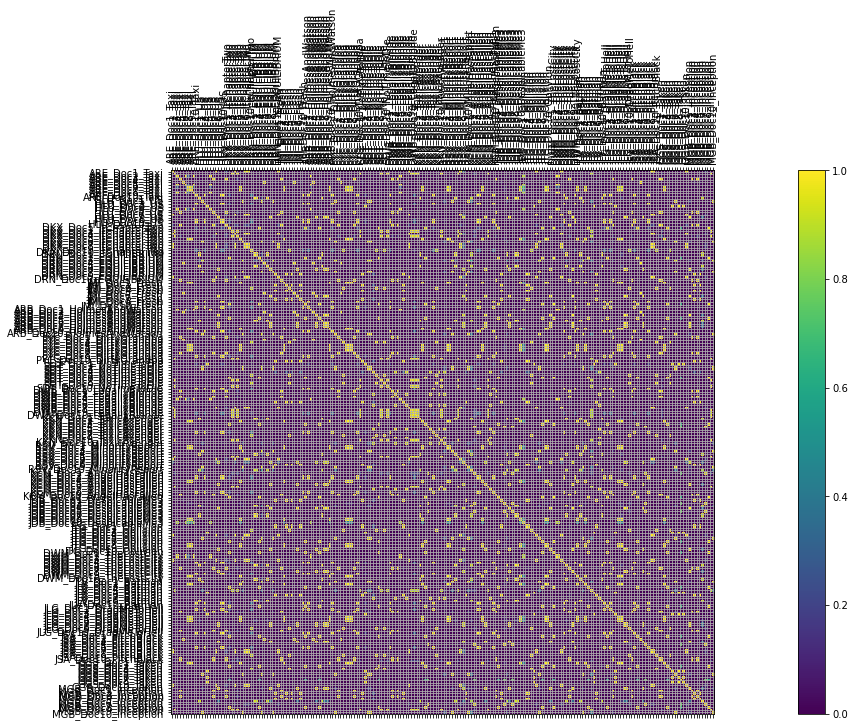

In [45]:
model2, dictionary2, index2, doctermmatrix2 = create_gensim_lda_model(processed_text,
                                                                      number_of_topics,
                                                                      words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

In [46]:
#topics = [idx for idx in range(2, 31)]

#coherence_values_10 = []

#for n_top in topics:
#    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text, n_top, 10)
#    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_values_10.append(coherence_lda)
    
#for idx, item in enumerate(coherence_values_10):
#    print(f"{topics[idx]} topics 10 words : {round(coherence_values_10[idx], 4)}") # 4 or 7 best?

# . . .

#plt.plot(topics, coherence_values_10)
#plt.scatter(topics, coherence_values_10)
#plt.plot(topics, coherence_values_35)
#plt.scatter(topics, coherence_values_35)
#plt.plot(topics, coherence_values_50)
#plt.scatter(topics, coherence_values_50)
#plt.plot(topics, coherence_values_100)
#plt.scatter(topics, coherence_values_100)
#plt.title('Number of Topics vs. Coherence')
#plt.xlabel('Number of Topics')
#plt.ylabel('Coherence')
#plt.xticks(topics)
#plt.legend(handles=[mpatches.Patch(color='blue', label='10 words'),
#                    mpatches.Patch(color='orange', label='35 words'),
#                    mpatches.Patch(color='green', label='50 words'),
#                    mpatches.Patch(color='red', label='100 words'),])
#plt.show()

# these are all kind of suggesting 3 topics or 7 topics
# since the words start to repeat after 3 topics, I'll use that
# however it's still pretty weak

## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

### KMeans Clustering

### K-Means Experiment with 3D Plot

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [47]:
cluster_title, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = 2)

cluster 0 :  ['HLU_Doc3_US', 'HLU_Doc9_US', 'DRN_Doc1_EQUILIBRIUM', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'DRN_Doc8_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'DRN_Doc10_EQUILIBRIUM', 'RSV_Doc1_MinorityReport', 'RSV_Doc2_MinorityReport', 'RSV_Doc3_MinorityReport', 'RSV_Doc4_MinorityReport', 'RSV_Doc5_MinorityReport', 'RSV_Doc6_MinorityReport', 'RSV_Doc7_MinorityReport', 'RSV_Doc9_MinorityReport', 'KCM_Doc10_AngelHasFallen', 'JTG_Doc8_Oblivion', 'DWM_Doc3_TheLostCity', 'JLV_Doc3_Batman', 'JLG_Doc9_DragMeToHell', 'JSA_Doc9_PitchBlack', 'JSA_Doc10_PitchBlack', 'GGS_Doc9_Taken', 'GGS_Doc10_Taken', 'MGB_Doc2_Inception'] 

cluster 1 :  ['ARE_Doc1_Taxi', 'ARE_Doc2_Taxi', 'ARE_Doc3_Taxi', 'ARE_Doc4_Taxi', 'ARE_Doc5_Taxi', 'ARE_Doc6_Taxi', 'ARE_Doc7_Taxi', 'ARE_Doc8_Taxi', 'ARE_Doc9_Taxi', 'ARE_Doc10_Taxi', 'HLU_Doc1_US', 'HLU_Doc2_US', 'HLU_Doc4_US', 'HLU_Doc5_US', 'HLU_Doc6_US', 'HLU_Doc7_US', 'HLU_Doc8_US', 'HLU_Doc

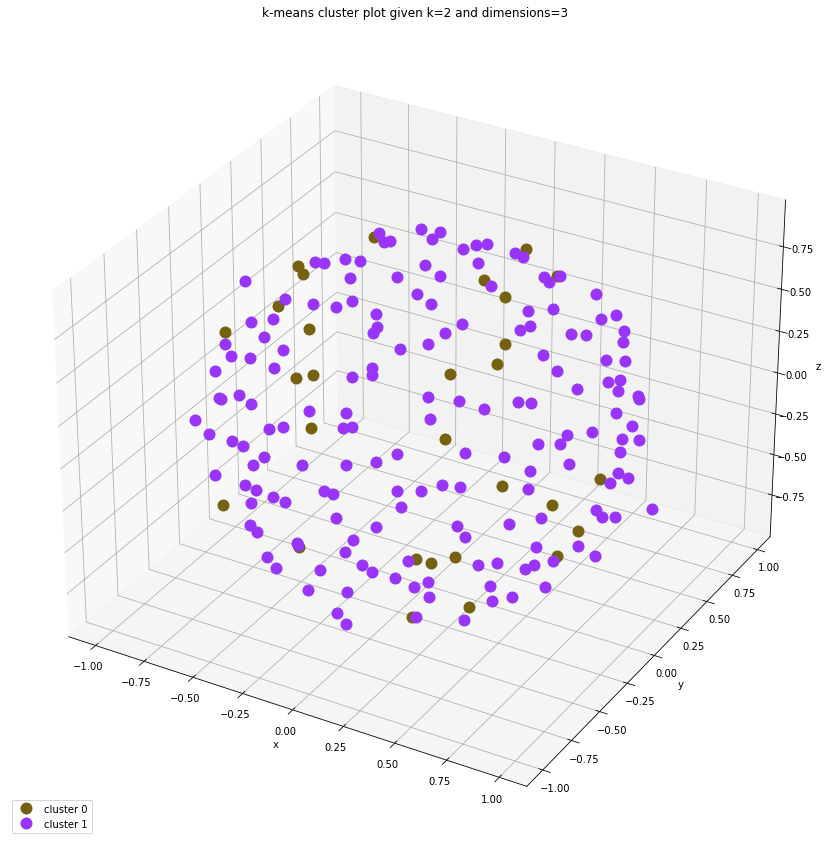

In [48]:
%matplotlib inline

# this does not suggest positive and negative reviews is a 50/50 split
plot_kmeans(k_value=2, dimensions=3)

cluster 0 :  ['ARE_Doc1_Taxi', 'ARE_Doc2_Taxi', 'ARE_Doc3_Taxi', 'ARE_Doc7_Taxi', 'ARE_Doc10_Taxi', 'HLU_Doc1_US', 'HLU_Doc2_US', 'HLU_Doc3_US', 'HLU_Doc4_US', 'HLU_Doc6_US', 'HLU_Doc8_US', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc6_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'JMI_Doc1_Fresh', 'JMI_Doc6_Fresh', 'ARB_Doc2_HolmesAndWatson', 'ARB_Doc3_HolmesAndWatson', 'ARB_Doc4_HolmesAndWatson', 'ARB_Doc5_HolmesAndWatson', 'ARB_Doc6_HolmesAndWatson', 'ARB_Doc9_HolmesAndWatson', 'PYC_Doc3_DirtyGrandpa', 'PYC_Doc4_DirtyGrandpa', 'PYC_Doc5_DirtyGrandpa', 'PYC_Doc10_DirtyGrandpa', 'SDT_Doc3_NoTimeToDie', 'SDT_Doc5_NoTimeToDie', 'SDT_Doc8_NoTimeToDie', 'SDT_Doc9_NoTimeToDie', 'SDT_Doc10_NoTimeToDie', 'DWB_Doc7_LegallyBlonde', 'DWB_Doc10_LegallyBlonde', 'KKN_Doc2_ToxicAvenger', 'KKN_Doc3_ToxicAvenger', 'KKN_Doc8_ToxicAvenger', 'KKN_Doc10_ToxicAvenger', 'RSV_Doc3_MinorityReport', 'RSV_Doc4_MinorityReport', 'RSV_Doc8_MinorityReport', 'KCM_Doc5_AngelHasFallen', 'K

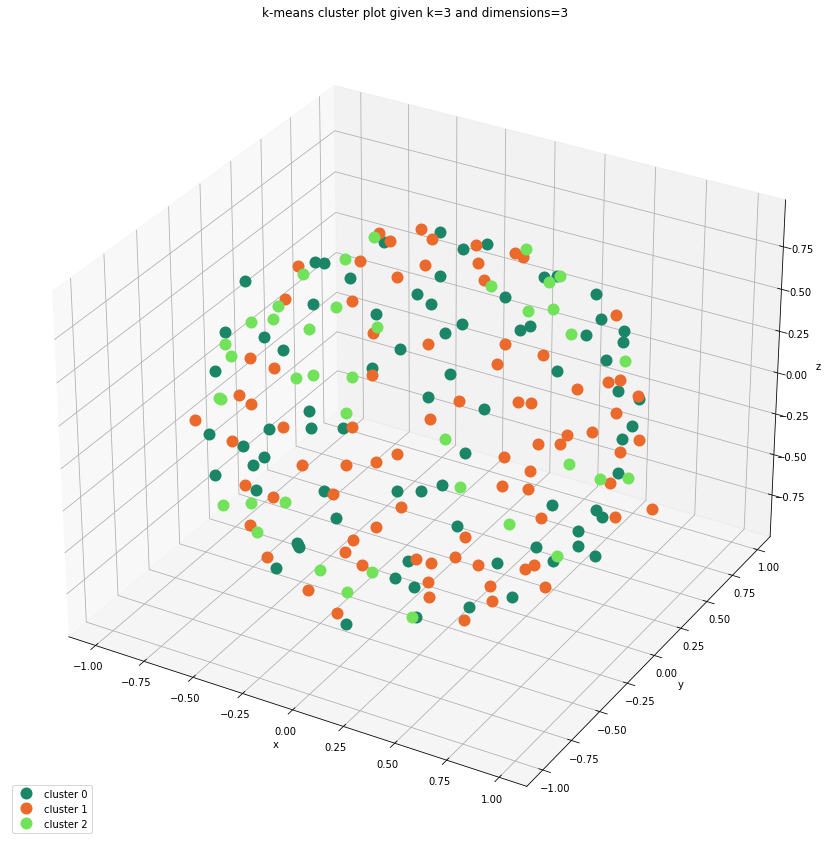

In [49]:
%matplotlib inline

# this does not suggest positive and negative reviews is a 50/50 split
plot_kmeans(k_value=3, dimensions=3)

cluster 0 :  ['JMI_Doc1_Fresh', 'JMI_Doc2_Fresh', 'JMI_Doc3_Fresh', 'JMI_Doc4_Fresh', 'JMI_Doc5_Fresh', 'JMI_Doc6_Fresh', 'JMI_Doc7_Fresh', 'JMI_Doc8_Fresh', 'JMI_Doc9_Fresh', 'PYC_Doc1_DirtyGrandpa', 'KKN_Doc6_ToxicAvenger', 'KCM_Doc8_AngelHasFallen'] 

cluster 1 :  ['ARE_Doc1_Taxi', 'ARE_Doc3_Taxi', 'ARE_Doc4_Taxi', 'ARE_Doc5_Taxi', 'ARE_Doc7_Taxi', 'ARE_Doc10_Taxi', 'HLU_Doc1_US', 'HLU_Doc3_US', 'HLU_Doc7_US', 'HLU_Doc8_US', 'HLU_Doc10_US', 'DKX_Doc2_ItChapterTwo', 'DKX_Doc5_ItChapterTwo', 'DKX_Doc7_ItChapterTwo', 'DKX_Doc8_ItChapterTwo', 'DKX_Doc9_ItChapterTwo', 'DRN_Doc1_EQUILIBRIUM', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'DRN_Doc8_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'DRN_Doc10_EQUILIBRIUM', 'JMI_Doc10_Fresh', 'ARB_Doc2_HolmesAndWatson', 'ARB_Doc6_HolmesAndWatson', 'ARB_Doc8_HolmesAndWatson', 'ARB_Doc9_HolmesAndWatson', 'PYC_Doc3_DirtyGrandpa', 'PYC_Doc4_DirtyGrandpa', 'PYC_Doc8_DirtyGrandpa', 'PYC

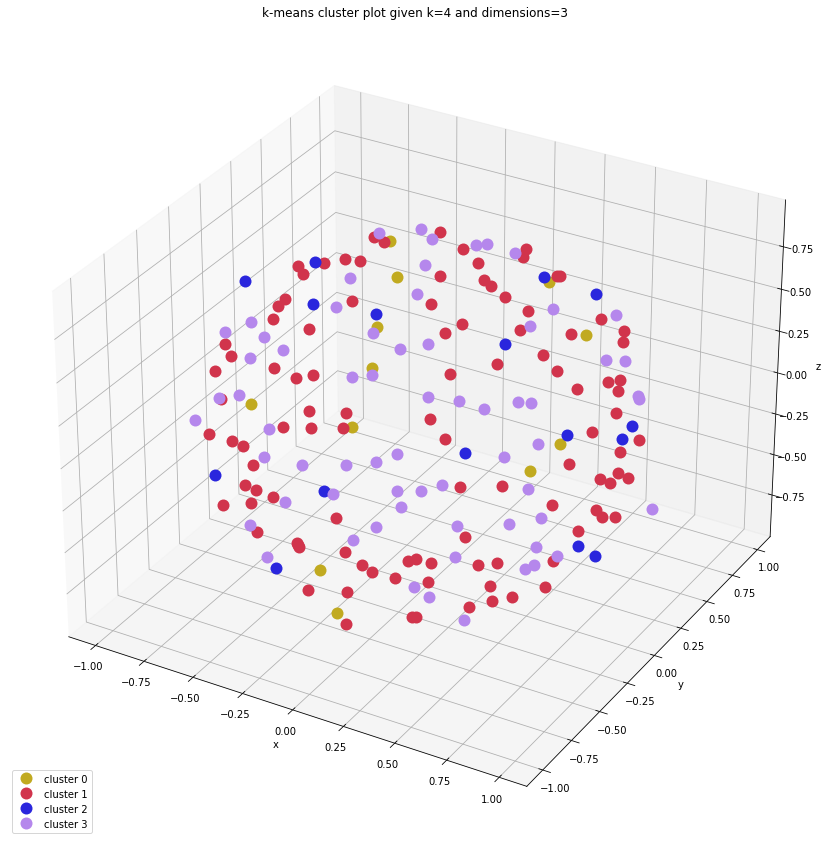

In [50]:
%matplotlib inline

plot_kmeans(k_value=4, dimensions=3)

cluster 0 :  ['JTG_Doc2_Oblivion', 'JTG_Doc3_Oblivion', 'JTG_Doc4_Oblivion', 'JTG_Doc9_Oblivion'] 

cluster 1 :  ['ARE_Doc5_Taxi', 'HLU_Doc8_US', 'PYC_Doc8_DirtyGrandpa', 'SDT_Doc1_NoTimeToDie', 'RSV_Doc1_MinorityReport', 'RSV_Doc2_MinorityReport', 'RSV_Doc3_MinorityReport', 'RSV_Doc4_MinorityReport', 'RSV_Doc5_MinorityReport', 'RSV_Doc6_MinorityReport', 'RSV_Doc7_MinorityReport', 'RSV_Doc8_MinorityReport', 'RSV_Doc9_MinorityReport', 'RSV_Doc10_MinorityReport', 'JTG_Doc1_Oblivion', 'JTG_Doc5_Oblivion', 'JTG_Doc6_Oblivion', 'JTG_Doc7_Oblivion', 'JTG_Doc10_Oblivion', 'JLV_Doc9_Batman'] 

cluster 2 :  ['HLU_Doc2_US', 'HLU_Doc4_US', 'HLU_Doc6_US', 'PYC_Doc10_DirtyGrandpa', 'KKN_Doc9_ToxicAvenger', 'JLG_Doc1_DragMeToHell', 'JLG_Doc2_DragMeToHell', 'JLG_Doc3_DragMeToHell', 'JLG_Doc4_DragMeToHell', 'JLG_Doc5_DragMeToHell', 'JLG_Doc6_DragMeToHell', 'JLG_Doc7_DragMeToHell', 'JLG_Doc8_DragMeToHell', 'JLG_Doc9_DragMeToHell', 'JLG_Doc10_DragMeToHell'] 

cluster 3 :  ['HLU_Doc9_US', 'DKX_Doc1_ItCha

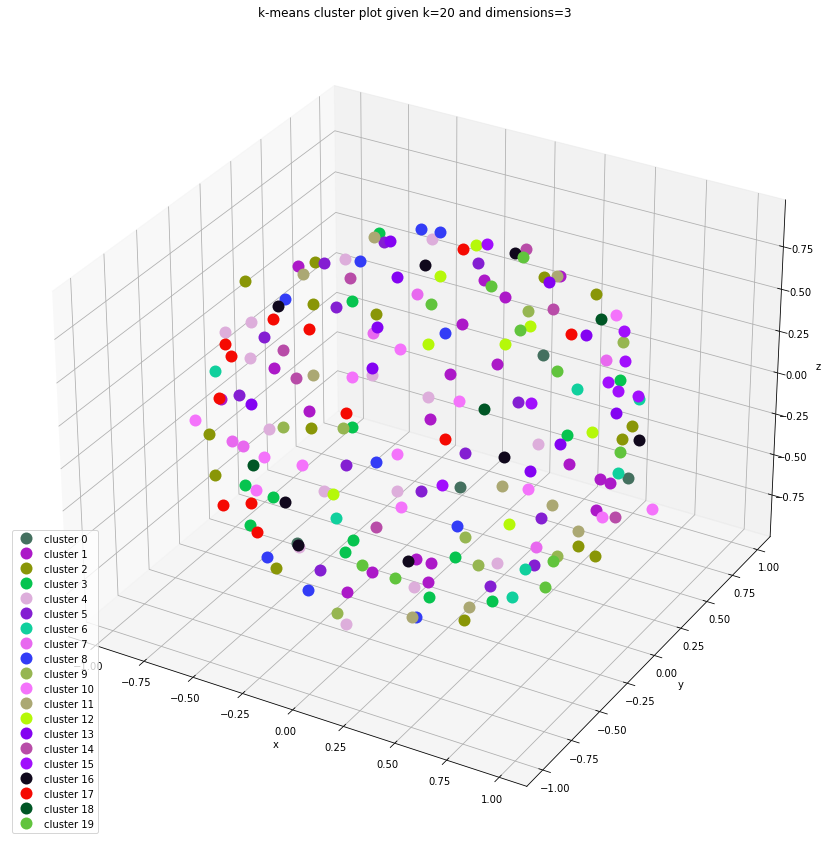

In [51]:
plot_kmeans(k_value=20, dimensions=3)

In [52]:
cluster_title, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = 4)

### Generate Labels for Supervised Learning Models

In [53]:
pos_neg_labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)

In [54]:
data['GenreCode'] = data['Genre of Movie'].astype("category").cat.codes
genre_labels = data['GenreCode']

### Create Results Table

In [55]:
#Create a dataframe to store the model accuracy and scores
results_tbl = pd.DataFrame(columns=['Classifier_Type',
                                    'cv_value',
                                    'Sentiment_or_Genre',
                                    'Accuracy',
                                    'Precision',
                                    'ROC_AUC',
                                    'Recall',
                                    'F1'
                                   ])
results_tbl.columns

Index(['Classifier_Type', 'cv_value', 'Sentiment_or_Genre', 'Accuracy',
       'Precision', 'ROC_AUC', 'Recall', 'F1'],
      dtype='object')

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [56]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'sent', 200)

CPU times: user 3min 49s, sys: 3.42 s, total: 3min 53s
Wall time: 2min 19s


In [57]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes', results_tbl, 'gen', 200)

CPU times: user 3min 33s, sys: 2.38 s, total: 3min 35s
Wall time: 1min 57s


### Logistic Regression Model 

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [58]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'sent', 200)

CPU times: user 4min 32s, sys: 7.43 s, total: 4min 39s
Wall time: 2min 33s


In [59]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'logistic', results_tbl, 'gen', 200)

CPU times: user 5min 12s, sys: 6.65 s, total: 5min 19s
Wall time: 3min


### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [60]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'sent', 200)

CPU times: user 3min 36s, sys: 3.69 s, total: 3min 40s
Wall time: 3min 46s


In [61]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'randomforest', results_tbl, 'gen', 200)

CPU times: user 3min 34s, sys: 3.81 s, total: 3min 38s
Wall time: 3min 45s


### Support Vector Machines 

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br> 
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [62]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'sent', 200)

CPU times: user 7min 17s, sys: 5.89 s, total: 7min 23s
Wall time: 3min 57s


In [63]:
%%time

results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 3)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 10)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 25)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 50)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 100)
results_tbl = classifiers(tfidf_matrix, pos_neg_labels, 'svm', results_tbl, 'gen', 200)

CPU times: user 6min 57s, sys: 4.41 s, total: 7min 2s
Wall time: 3min 39s


In [64]:
results_tbl.round(decimals = 3)

,Classifier_Type,cv_value,Sentiment_or_Genre,Accuracy,Precision,ROC_AUC,Recall,F1
0,naive_bayes,3,sent,0.879,0.775,0.5,0.879,0.823
1,naive_bayes,10,sent,0.877,0.771,0.5,0.877,0.820
2,naive_bayes,25,sent,0.861,0.742,0.5,0.861,0.796
3,naive_bayes,50,sent,0.863,0.746,0.5,0.863,0.800
4,naive_bayes,100,sent,0.860,0.740,0.5,0.860,0.795
5,naive_bayes,200,sent,0.864,0.747,0.5,0.864,0.801
6,naive_bayes,3,gen,0.859,0.738,-,0.859,0.794
7,naive_bayes,10,gen,0.861,0.741,-,0.861,0.796
8,naive_bayes,25,gen,0.865,0.750,-,0.865,0.803
9,naive_bayes,50,gen,0.859,0.739,-,0.859,0.794


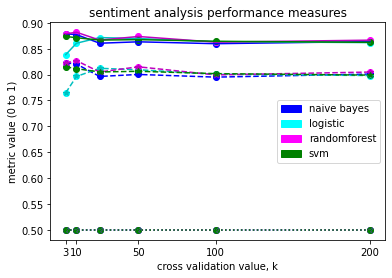

In [65]:
plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], 'b')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], color='blue')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], 'c')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], color='cyan')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], 'm')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], color='magenta')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], 'g')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], color='green')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], 'b*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], color='blue')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], 'c*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], color='cyan')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], 'm*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], color='magenta')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], 'g*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], color='green')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], 'b3:')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='sent')], color='blue')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], 'c3:')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='sent')], color='cyan')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], 'm3:')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='sent')], color='magenta')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], 'g3:')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='sent'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.ROC_AUC.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='sent')], color='green')

# f1 is dashed line
# accuracy is solid line
# roc is dotted line

plt.title('sentiment analysis performance measures')
plt.xlabel('cross validation value, k')
plt.ylabel('metric value (0 to 1)')
plt.xticks([3, 10, 50, 100, 200])
plt.legend(handles=[mpatches.Patch(color='blue', label='naive bayes'),
                    mpatches.Patch(color='cyan', label='logistic'),
                    mpatches.Patch(color='magenta', label='randomforest'),
                    mpatches.Patch(color='green', label='svm'),], loc='best')
plt.show()

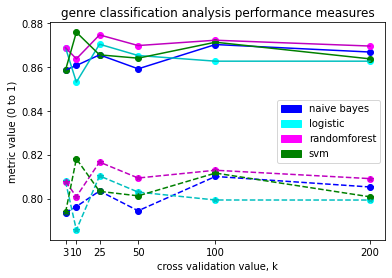

In [66]:
plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='gen')], 'b')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='gen')], color='blue')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='gen')], 'c')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='gen')], color='cyan')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='gen')], 'm')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='gen')], color='magenta')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='gen')], 'g')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.Accuracy.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='gen')], color='green')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='gen')], 'b*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='naive_bayes'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='naive_bayes') & (results_tbl.Sentiment_or_Genre=='gen')], color='blue')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='gen')], 'c*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='logistic'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='logistic') & (results_tbl.Sentiment_or_Genre=='gen')], color='cyan')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='gen')], 'm*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='randomforest'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='randomforest') & (results_tbl.Sentiment_or_Genre=='gen')], color='magenta')

plt.plot(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='gen')], 'g*--')
plt.scatter(results_tbl.loc[results_tbl.Sentiment_or_Genre=='gen'].cv_value.loc[results_tbl.Classifier_Type=='svm'], results_tbl.F1.loc[(results_tbl.Classifier_Type=='svm') & (results_tbl.Sentiment_or_Genre=='gen')], color='green')

# f1 is dashed line
# accuracy is solid line

plt.title('genre classification analysis performance measures')
plt.xlabel('cross validation value, k')
plt.ylabel('metric value (0 to 1)')
plt.xticks([3, 10, 25, 50, 100, 200])
plt.legend(handles=[mpatches.Patch(color='blue', label='naive bayes'),
                    mpatches.Patch(color='cyan', label='logistic'),
                    mpatches.Patch(color='magenta', label='randomforest'),
                    mpatches.Patch(color='green', label='svm'),], loc='best')
plt.show()

greetings. printing model topic observations for n topics 20
topic 0
(0, '-0.313*"make" + -0.145*"take" + -0.128*"come" + -0.125*"play" + -0.115*"give" + -0.106*"character" + -0.102*"seem" + -0.091*"film" + -0.090*"thing" + -0.086*"every"')


topic 1
(1, '0.277*"technology" + 0.120*"scanner" + -0.117*"make" + 0.103*"future" + 0.102*"build" + 0.100*"spielberg" + 0.099*"officer" + 0.099*"predict" + 0.094*"dangerous" + 0.094*"escape"')


topic 2
(2, '-0.170*"emotion" + -0.160*"certainly" + -0.116*"film\'s" + -0.113*"emotion," + -0.113*"mankind" + -0.111*"danger" + -0.110*"price" + -0.109*"essence" + -0.109*"often" + -0.108*"sacrifice"')


topic 3
(3, '-0.261*"social" + -0.140*"right" + -0.139*"however," + -0.117*"generally" + -0.115*"state" + -0.115*"view" + -0.113*"willing" + -0.111*"concern" + -0.110*"provide" + -0.104*"filmmaker"')


topic 4
(4, '-0.148*"turn" + -0.121*"play" + -0.116*"lose" + 0.111*"character" + 0.108*"give" + -0.108*"think" + 0.103*"franchise" + -0.095*"make" + -0.09

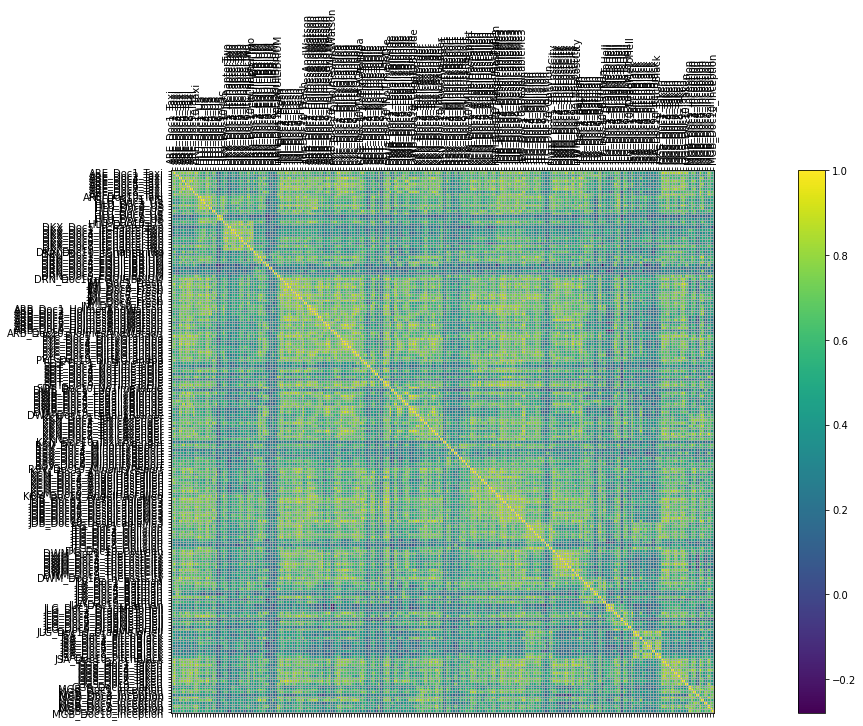

In [67]:
# dark purple means it didnt converge; it's just random
# not rly any underlying __ concepts being extracted based on model

# this should be the pretty one, where all the docs of the same movie are similar to one another

model_20topic_10words = plot_lsa(20, 10)

In [68]:
# tdm matrix as input

In [69]:
# it seems random forest model doesn't perform well on the genres but it
# does outperform logistic regression and naive bayes on the posi/neg reviews.

In [70]:
# you want like a scree plot
# with confusion matrix
# add precision, recall, f1 score

# add model type
# add whether you stemmed, lemm'ed

# for pos/neg review prediction

# divide data by genre
# pos/neg review prediction
# just for cluster 1
# what does it think?

# track the number of dimensions - before cleaning, after cleaning